In [1]:
# This part was copied from pytorch source code

import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet50(pretrained=True, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)




In [2]:
# Introduce the Conv2D network as a block that performs 1*1 convolution and then batch normalization and leakyrelu

class Conv2D(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=3, padding=1, stride=1, dilation=1, bias=True, act=True):
        super().__init__()

        self.act = act
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size, padding=padding, dilation=dilation, stride=stride, bias=bias),
            nn.BatchNorm2d(out_c)
        )
        self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)

    def forward(self, x):
        x = self.conv(x)
        
#         Check if relu is needed or not
        if self.act == True:
            x = self.relu(x)
        return x

#     Introduce each normal residual block
class residual_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

#        conv = conv2d(introduced above) + batch normalization + leakyrelu + conv2d + batch normalization
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c)
        )
#     residual part : conv2d + batch normalization
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_c)
        )
        self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)

    def forward(self, inputs):
        x = self.conv(inputs)
        s = self.shortcut(inputs)
#       relu(conv + shortcut)
        return self.relu(x + s)

# defining RT block
class residual_transformer_block(nn.Module):
    def __init__(self, in_c, out_c, patch_size=4, num_heads=4, num_layers=2, dim=None):
        super().__init__()

        self.ps = patch_size
        self.c1 = Conv2D(in_c, out_c)
        
#         The encoder layer uses the transformerencoderlayer of pytorch
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=num_heads)
        self.te = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.c2 = Conv2D(out_c, out_c, kernel_size=1, padding=0, act=False)
        self.c3 = Conv2D(in_c, out_c, kernel_size=1, padding=0, act=False)
        self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.r1 = residual_block(out_c, out_c)

    def forward(self, inputs):
#         perform conv (3*3)
        x = self.c1(inputs)
#         reshape  to patches
        b, c, h, w = x.shape
        num_patches = (h*w)//(self.ps**2)
        x = torch.reshape(x, (b, (self.ps**2)*c, num_patches))
#         pass through the transformer encoder layer
        x = self.te(x)
        x = torch.reshape(x, (b, c, h, w))

#         pass through conv
        x = self.c2(x)
#        for residual part (shortcut) pass input to conv and then perform relu on (main + shortcut)
        s = self.c3(inputs)
        x = self.relu(x + s)
#        pass through a normal residual block
        x = self.r1(x)
        return x

#     Define the main model
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        backbone = resnet50()
#         4 intermediate feature maps
        self.layer0 = nn.Sequential(backbone.conv1, backbone.bn1, backbone.relu)
        self.layer1 = nn.Sequential(backbone.maxpool, backbone.layer1)
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4

        self.e1 = Conv2D(64, 64, kernel_size=1, padding=0)
        self.e2 = Conv2D(256, 64, kernel_size=1, padding=0)
        self.e3 = Conv2D(512, 64, kernel_size=1, padding=0)
        self.e4 = Conv2D(1024, 64, kernel_size=1, padding=0)


        """ Decoder """
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.r1 = residual_transformer_block(64+64, 64, dim=64)
        self.r2 = residual_transformer_block(64+64, 64, dim=256)
        self.r3 = residual_block(64+64, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        x0 = inputs
        x1 = self.layer0(x0)   
        x2 = self.layer1(x1)   
        x3 = self.layer2(x2)    
        x4 = self.layer3(x3)    


        e1 = self.e1(x1)
        e2 = self.e2(x2)
        e3 = self.e3(x3)
        e4 = self.e4(x4)

        """ Decoder """
#         Upsample
        x = self.up(e4)
#         concat
        x = torch.cat([x, e3], axis=1)
#          Relu
        x = self.r1(x)
# Repeat
        x = self.up(x)
        x = torch.cat([x, e2], axis=1)
        x = self.r2(x)

        x = self.up(x)
        x = torch.cat([x, e1], axis=1)
        x = self.r3(x)

        x = self.up(x)

        """ Classifier """
        outputs = self.outputs(x)
        return outputs

if __name__ == "__main__":
    x = torch.randn((4, 3, 256, 256))
    model = Model()
    y = model(x)
#     Check the shape
    print(y.shape)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 219MB/s] 
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([4, 1, 256, 256])


In [3]:
# Defining evaluation functions

import torch.nn.functional as F
from scipy.spatial.distance import directed_hausdorff

""" Loss Functions- """
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

""" Metrics ------------------------------------------ """
def precision(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    return (intersection + 1e-15) / (y_pred.sum() + 1e-15)

def recall(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    return (intersection + 1e-15) / (y_true.sum() + 1e-15)

def F2(y_true, y_pred, beta=2):
    p = precision(y_true,y_pred)
    r = recall(y_true, y_pred)
    return (1+beta**2.) *(p*r) / float(beta**2*p + r + 1e-15)

def dice_score(y_true, y_pred):
    return (2 * (y_true * y_pred).sum() + 1e-15) / (y_true.sum() + y_pred.sum() + 1e-15)

def jac_score(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return (intersection + 1e-15) / (union + 1e-15)


def hd_dist(preds, targets):
    haussdorf_dist = directed_hausdorff(preds, targets)[0]
    return haussdorf_dist

In [4]:
# Some needed utilities
import os
import random
import numpy as np
import cv2
from tqdm import tqdm
import torch
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix

""" Seeding the randomness. """
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

""" Create a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

""" Shuffle the dataset. """
def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def print_and_save(file_path, data_str):
    print(data_str)
    with open(file_path, "a") as file:
        file.write(data_str)
        file.write("\n")

def calculate_metrics(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()

    y_pred = y_pred > 0.5
    y_pred = y_pred.reshape(-1)
    y_pred = y_pred.astype(np.uint8)

    y_true = y_true > 0.5
    y_true = y_true.reshape(-1)
    y_true = y_true.astype(np.uint8)


    score_jaccard = jac_score(y_true, y_pred)
    score_f1 = dice_score(y_true, y_pred)
    score_recall = recall(y_true, y_pred)
    score_precision = precision(y_true, y_pred)
    score_fbeta = F2(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)

    return [score_jaccard, score_f1, score_recall, score_precision, score_acc, score_fbeta]


In [5]:
import sys
import os
import glob
import random
import time

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt



In [6]:
DATA_PATH = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"

# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# img size
IMG_SIZE = 512

In [7]:
data_map = []
for sub_dir_path in glob.glob(DATA_PATH+"*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
    else:
        print("This is not a dir:", sub_dir_path)
        
        
df = pd.DataFrame({"dirname" : data_map[::2],
                  "path" : data_map[1::2]})
df.head()

This is not a dir: /kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
This is not a dir: /kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv


,dirname,path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [8]:
# Divide images ans masks
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

df = pd.DataFrame({"patient": df_imgs.dirname.values,
                       "image_path": imgs,
                   "mask_path": masks})

# Check if the MRI is non-tumorous
def is_mask_completely_black(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    return np.max(mask) == 0


# Filter the DataFrame
filtered_df = df[~df['mask_path'].apply(is_mask_completely_black)]

# Print the filtered DataFrame
print(filtered_df)
df = filtered_df.copy()

Path to the Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_33.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_33_mask.tif
                    patient  \
537   TCGA_DU_7300_19910814   
541   TCGA_DU_7300_19910814   
562   TCGA_DU_7018_19911220   
576   TCGA_DU_7018_19911220   
621   TCGA_DU_7301_19911112   
...                     ...   
3776  TCGA_DU_A5TU_19980312   
3789  TCGA_HT_A616_19991226   
3790  TCGA_HT_A616_19991226   
3801  TCGA_HT_A616_19991226   
3802  TCGA_HT_A616_19991226   

                                             image_path  \
537   /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
541   /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
562   /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
576   /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
621   /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
...                                   

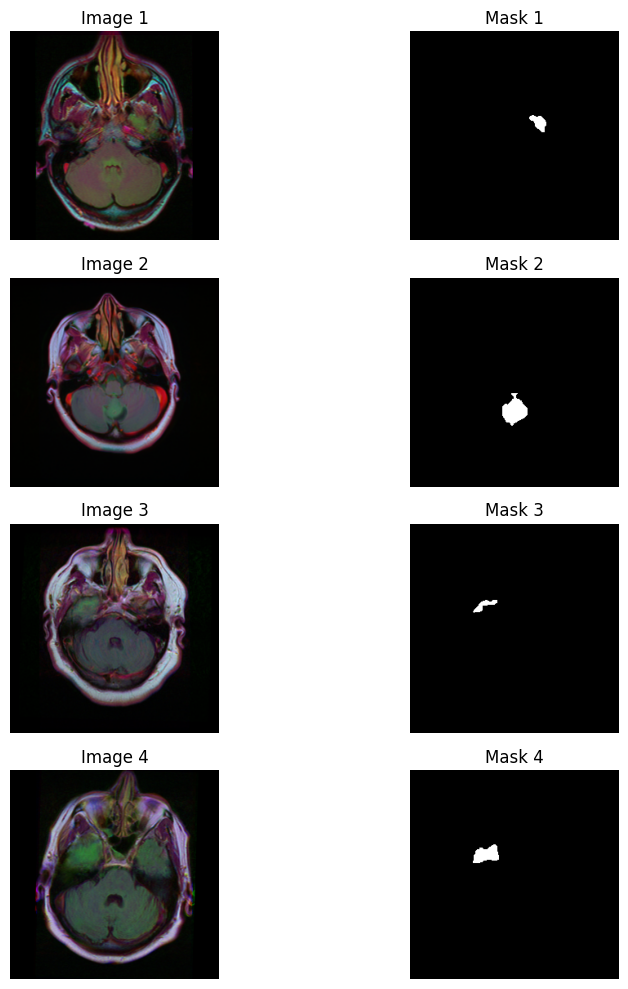

In [9]:
from PIL import Image
def plot_images_and_masks(df, n=4):
    fig, axes = plt.subplots(n, 2, figsize=(10, 10))
    
    for i in range(n):
        image_path = df.iloc[i]['image_path']
        mask_path = df.iloc[i]['mask_path']
        
        # Load image and mask
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path)
        
        # Plot image
        axes[i, 0].imshow(image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f'Image {i+1}')
        
        # Plot mask
        axes[i, 1].imshow(mask)
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f'Mask {i+1}')
    
    plt.tight_layout()
    plt.show()

# Plot the images and masks
plot_images_and_masks(df)


In [10]:
# Divide dataframe to train and test
from sklearn.model_selection import train_test_split
df_train, df_test= train_test_split(df, test_size=0.2, random_state=42)
print(df_train.shape)
print(df_test.shape)

(1098, 3)
(275, 3)


In [11]:
import os
import random
import time
import datetime
import numpy as np
import albumentations as A
import cv2
from PIL import Image
from glob import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split


def load_data():
#     Divide train and test
    X_train, X_valid, Y_train, Y_valid = train_test_split(df_train['image_path'], df_train['mask_path'], test_size=0.2, random_state=42)
    
#     Change into list for training
    train_x = X_train.tolist()
    train_y = Y_train.tolist()
    valid_x = X_valid.tolist()
    valid_y = Y_valid.tolist()

    return (train_x, train_y), (valid_x, valid_y)

class DATASET(Dataset):
    def __init__(self, images_path, masks_path, size, transform=None):
        super().__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.transform = transform
        self.n_samples = len(images_path)

    def __getitem__(self, index):
#         read the image and mask from the path in df
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        
# Perform transformation if included in the arguments
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

#             Change images and mask to proper size and dimension
        image = cv2.resize(image, size)
        image = np.transpose(image, (2, 0, 1))
        image = image/255.0

        mask = cv2.resize(mask, size)
        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0

        return image, mask

    def __len__(self):
        return self.n_samples

def train(model, loader, optimizer, loss_fn, device):
    model.train()

    epoch_loss = 0.0
    epoch_jac = 0.0
    epoch_f1 = 0.0
    epoch_recall = 0.0
    epoch_precision = 0.0

    for i, (x, y) in enumerate(loader):
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
#         Calculate loss
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        """ Calculate the metrics """
        batch_jac = []
        batch_f1 = []
        batch_recall = []
        batch_precision = []

        for yt, yp in zip(y, y_pred):
            score = calculate_metrics(yt, yp)
            batch_jac.append(score[0])
            batch_f1.append(score[1])
            batch_recall.append(score[2])
            batch_precision.append(score[3])
            
#         Get the mean the batch metric to calculate the metrics for each epoch
        epoch_jac += np.mean(batch_jac)
        epoch_f1 += np.mean(batch_f1)
        epoch_recall += np.mean(batch_recall)
        epoch_precision += np.mean(batch_precision)

    epoch_loss = epoch_loss/len(loader)
    epoch_jac = epoch_jac/len(loader)
    epoch_f1 = epoch_f1/len(loader)
    epoch_recall = epoch_recall/len(loader)
    epoch_precision = epoch_precision/len(loader)

    return epoch_loss, [epoch_jac, epoch_f1, epoch_recall, epoch_precision]

def evaluate(model, loader, loss_fn, device):
    model.eval()
# Same as train
    epoch_loss = 0
    epoch_loss = 0.0
    epoch_jac = 0.0
    epoch_f1 = 0.0
    epoch_recall = 0.0
    epoch_precision = 0.0

    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

            """ Calculate the metrics """
            batch_jac = []
            batch_f1 = []
            batch_recall = []
            batch_precision = []

            for yt, yp in zip(y, y_pred):
                score = calculate_metrics(yt, yp)
                batch_jac.append(score[0])
                batch_f1.append(score[1])
                batch_recall.append(score[2])
                batch_precision.append(score[3])

            epoch_jac += np.mean(batch_jac)
            epoch_f1 += np.mean(batch_f1)
            epoch_recall += np.mean(batch_recall)
            epoch_precision += np.mean(batch_precision)

        epoch_loss = epoch_loss/len(loader)
        epoch_jac = epoch_jac/len(loader)
        epoch_f1 = epoch_f1/len(loader)
        epoch_recall = epoch_recall/len(loader)
        epoch_precision = epoch_precision/len(loader)

        return epoch_loss, [epoch_jac, epoch_f1, epoch_recall, epoch_precision]

if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Directories """
    create_dir("files")

    """ Training logfile """
    train_log_path = "files/train_log.txt"
    if os.path.exists(train_log_path):
        print("Log file exists")
    else:
        train_log = open("files/train_log.txt", "w")
        train_log.write("\n")
        train_log.close()

    """ Record Date & Time """
    datetime_object = str(datetime.datetime.now())
    print_and_save(train_log_path, datetime_object)
    print("")

    """ Hyperparameters """
    image_size = 256
    size = (image_size, image_size)
    batch_size = 8
    num_epochs = 500
    lr = 1e-4
    early_stopping_patience = 50
    checkpoint_path = "files/checkpoint.pth"

    data_str = f"Image Size: {size}\nBatch Size: {batch_size}\nLR: {lr}\nEpochs: {num_epochs}\n"
    data_str += f"Early Stopping Patience: {early_stopping_patience}\n"
    print_and_save(train_log_path, data_str)

    """ Dataset """
    (train_x, train_y), (valid_x, valid_y) = load_data()
    train_x, train_y = shuffling(train_x, train_y)
    data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
    print_and_save(train_log_path, data_str)

    """ Data augmentation: Transforms """
#     Define the transformation
    transform =  A.Compose([
        A.Rotate(limit=35, p=0.3),
        A.HorizontalFlip(p=0.3),
        A.VerticalFlip(p=0.3),
        A.CoarseDropout(p=0.3, max_holes=10, max_height=32, max_width=32)
    ])

    """ Dataset and loader """
    train_dataset = DATASET(train_x, train_y, size, transform=transform)
    valid_dataset = DATASET(valid_x, valid_y, size, transform=None)

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    """ Model """
    device = torch.device('cuda')
    model = Model()
    model = model.to(device)
    
#     Define the optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
    loss_fn = DiceBCELoss()
    loss_name = "BCE Dice Loss"
    data_str = f"Optimizer: Adam\nLoss: {loss_name}\n"
    print_and_save(train_log_path, data_str)

    """ Training the model """
    best_valid_metrics = 0.0
    early_stopping_count = 0

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_metrics = train(model, train_loader, optimizer, loss_fn, device)
        valid_loss, valid_metrics = evaluate(model, valid_loader, loss_fn, device)
        scheduler.step(valid_loss)

#         Our main standard to compare is f1 as our data is imbalanced (background is the majority compared to foreground)
        if valid_metrics[1] > best_valid_metrics:
            data_str = f"Valid F1 improved from {best_valid_metrics:2.4f} to {valid_metrics[1]:2.4f}. Saving checkpoint: {checkpoint_path}"
            print_and_save(train_log_path, data_str)

            best_valid_metrics = valid_metrics[1]
            torch.save(model.state_dict(), checkpoint_path)
            early_stopping_count = 0

#             If f1 hasn't improved we get closer to early stopping
        elif valid_metrics[1] < best_valid_metrics:
            early_stopping_count += 1

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        data_str = f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n"
        data_str += f"\tTrain Loss: {train_loss:.4f} - Jaccard: {train_metrics[0]:.4f} - F1: {train_metrics[1]:.4f} - Recall: {train_metrics[2]:.4f} - Precision: {train_metrics[3]:.4f}\n"
        data_str += f"\t Val. Loss: {valid_loss:.4f} - Jaccard: {valid_metrics[0]:.4f} - F1: {valid_metrics[1]:.4f} - Recall: {valid_metrics[2]:.4f} - Precision: {valid_metrics[3]:.4f}\n"
        print_and_save(train_log_path, data_str)

#         check the early stopping condition
        if early_stopping_count == early_stopping_patience:
            data_str = f"Early stopping: validation loss stops improving from last {early_stopping_patience} continously.\n"
            print_and_save(train_log_path, data_str)
            break

2024-06-25 17:52:05.023631

Image Size: (256, 256)
Batch Size: 8
LR: 0.0001
Epochs: 500
Early Stopping Patience: 50

Dataset Size:
Train: 878 - Valid: 220



/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Optimizer: Adam
Loss: BCE Dice Loss

Valid F1 improved from 0.0000 to 0.6873. Saving checkpoint: files/checkpoint.pth
Epoch: 01 | Epoch Time: 0m 33s
	Train Loss: 1.0642 - Jaccard: 0.4800 - F1: 0.5953 - Recall: 0.7677 - Precision: 0.6035
	 Val. Loss: 0.8643 - Jaccard: 0.5766 - F1: 0.6873 - Recall: 0.7986 - Precision: 0.7318

Valid F1 improved from 0.6873 to 0.7497. Saving checkpoint: files/checkpoint.pth
Epoch: 02 | Epoch Time: 0m 32s
	Train Loss: 0.7981 - Jaccard: 0.6016 - F1: 0.7131 - Recall: 0.8170 - Precision: 0.7315
	 Val. Loss: 0.7178 - Jaccard: 0.6443 - F1: 0.7497 - Recall: 0.8248 - Precision: 0.7707

Epoch: 03 | Epoch Time: 0m 32s
	Train Loss: 0.6558 - Jaccard: 0.6448 - F1: 0.7535 - Recall: 0.8385 - Precision: 0.7575
	 Val. Loss: 0.5930 - Jaccard: 0.6221 - F1: 0.7199 - Recall: 0.7666 - Precision: 0.8186

Valid F1 improved from 0.7497 to 0.7716. Saving checkpoint: files/checkpoint.pth
Epoch: 04 | Epoch Time: 0m 32s
	Train Loss: 0.5382 - Jaccard: 0.6682 - F1: 0.7723 - Recall: 0.84

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 275/275 [00:06<00:00, 39.40it/s]


Jaccard: 0.7700 - F1: 0.8511 - Recall: 0.8622 - Precision: 0.8846 - Acc: 0.9952 - F2: 0.8546 - HD: 2.8647
----------------------------------------------------------------------
Mean FPS:  88.77287505062307


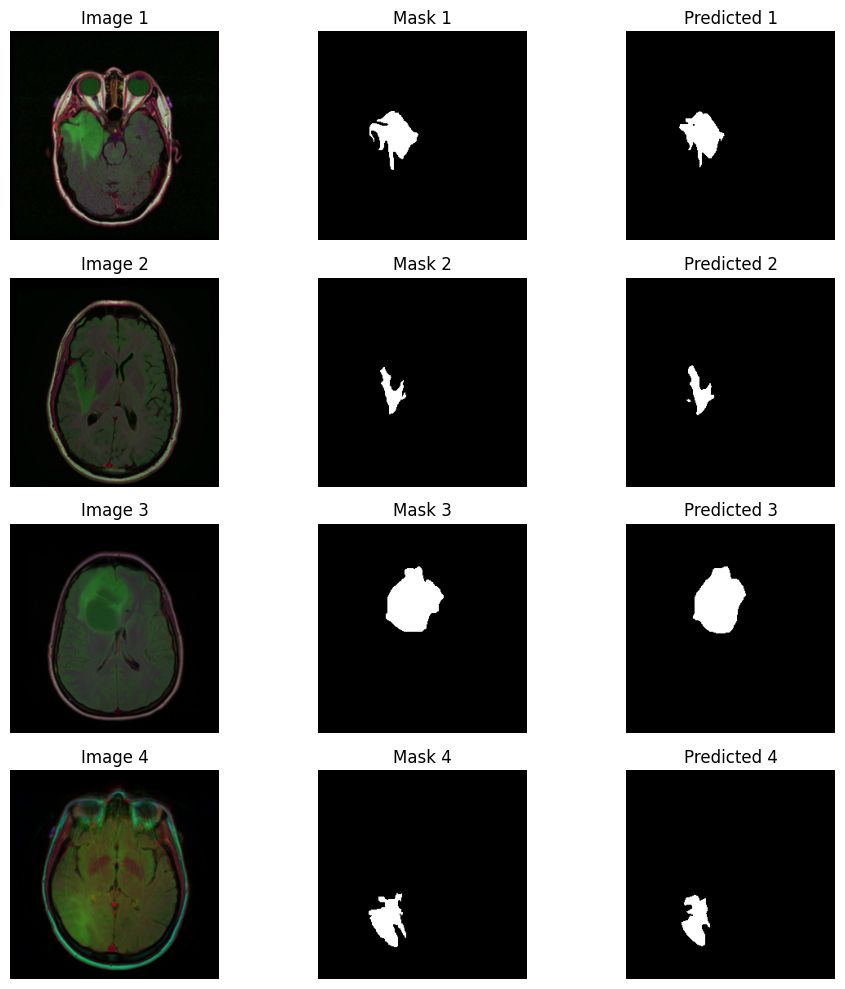

In [19]:
import os, time
from operator import add
import numpy as np
from glob import glob
import cv2
from tqdm import tqdm
import imageio
import torch


fig, axes = plt.subplots(4, 3, figsize=(10, 10))


def calculate_hd(y_true, y_pred):
    y_true = y_true[0][0].detach().cpu().numpy()
    y_pred = y_pred[0][0].detach().cpu().numpy()

    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)

    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)

    return hd_dist(y_true, y_pred)


def evaluate(model, test_x, test_y, size):
    metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    time_taken = []

    for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):

        
        """ Read Image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        image = cv2.resize(image, size)
#         save image for visualizing
        save_img = image
        image = np.transpose(image, (2, 0, 1))
        image = image/255.0
        image = np.expand_dims(image, axis=0)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)
        image = image.to(device)

        """ Mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, size)
#         Save mask for visualization
        save_mask = mask
        save_mask = np.expand_dims(save_mask, axis=-1)
        save_mask = np.concatenate([save_mask, save_mask, save_mask], axis=2)
        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = np.expand_dims(mask, axis=0)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)
        mask = mask.to(device)

        with torch.no_grad():
            """ FPS calculation """
            start_time = time.time()
            
            y_pred = model(image)
            y_pred = torch.sigmoid(y_pred)
            
            end_time = time.time() - start_time
            time_taken.append(end_time)

            """ Evaluation metrics """
            score = calculate_metrics(mask, y_pred)
            hd = calculate_hd(mask, y_pred)
            score.append(hd)
            
            metrics_score = list(map(add, metrics_score, score))

            """ Predicted Mask """
            y_pred = y_pred[0].cpu().numpy()
            y_pred = np.squeeze(y_pred, axis=0)
#             Change to black and white
            y_pred = y_pred > 0.5
            y_pred = y_pred.astype(np.int32)
            y_pred = y_pred * 255
            y_pred = np.array(y_pred, dtype=np.uint8)
            y_pred = np.expand_dims(y_pred, axis=-1)
            y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=2)
            
        if(i < 4):
            # Plot image
            axes[i, 0].imshow(save_img)
            axes[i, 0].axis('off')
            axes[i, 0].set_title(f'Image {i+1}')

            # Plot mask
            axes[i, 1].imshow(save_mask)
            axes[i, 1].axis('off')
            axes[i, 1].set_title(f'Mask {i+1}')


            # Plot Predicted
            axes[i, 2].imshow(y_pred)
            axes[i, 2].axis('off')
            axes[i, 2].set_title(f'Predicted {i+1}')

    

    jaccard = metrics_score[0]/len(test_x)
    f1 = metrics_score[1]/len(test_x)
    recall = metrics_score[2]/len(test_x)
    precision = metrics_score[3]/len(test_x)
    acc = metrics_score[4]/len(test_x)
    f2 = metrics_score[5]/len(test_x)
    hd = metrics_score[6]/len(test_x)

    print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f} - F2: {f2:1.4f} - HD: {hd:2.4f}")
    print("----------------------------------------------------------------------")
    mean_time_taken = np.mean(time_taken)
    mean_fps = 1/mean_time_taken
    print("Mean FPS: ", mean_fps)


if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Load the checkpoint """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Model()
    model = model.to(device)
    checkpoint_path = "/kaggle/working/files/checkpoint.pth"
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    """ Test dataset """
    
    test_x = df_test['image_path'].tolist()
    test_y = df_test['mask_path'].tolist()

    size = (256, 256)
    evaluate(model, test_x, test_y, size)
    plt.tight_layout()
    plt.show()

Thank you!